In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

1. Following the approach described in Section 8.2, plot the precision and recall
associated with a test as a function of $\theta \in [0, 1]$, where $\alpha=\beta=0.05$ and K=1.
Is this consistent with your intuition?

Recall이 안 변하는것 때문에 직관적이지는 않으나 여기서 $\theta$가 전략의 희소성을 의미하게 때문에 Recall에 전략을 주지 않는것으로 보인다.

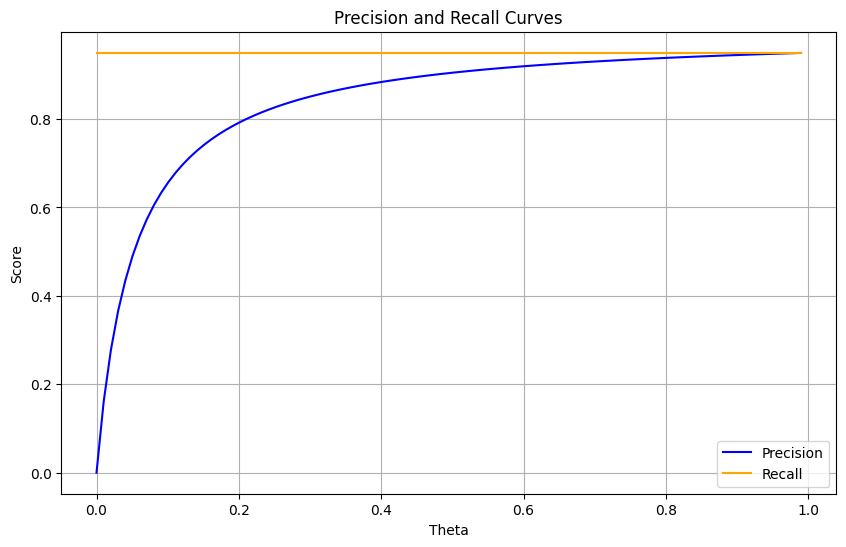

In [26]:
alpha=beta=0.05
precision_func=lambda x: (1-beta)*x/((1-beta)*x+alpha)
recall_func=lambda x: np.ones_like(x)*(1-beta)

x=np.linspace(0, 1, 100)[:-1]
precision=precision_func(x)
recall=recall_func(x)

plt.figure(figsize=(10, 6))
plt.plot(x, precision, label='Precision', color='blue')
plt.plot(x, recall, label='Recall', color='orange')
plt.title('Precision and Recall Curves')
plt.xlabel('Theta')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

2. Repeat Exercise 1, plotting a surface as a function of $K=1,...,25$. 
What is the overall effect of multiple testing on precision and recall?

Recall은 K가 커질수록 약간 증가, Precision은 점점 크게 감소한다.

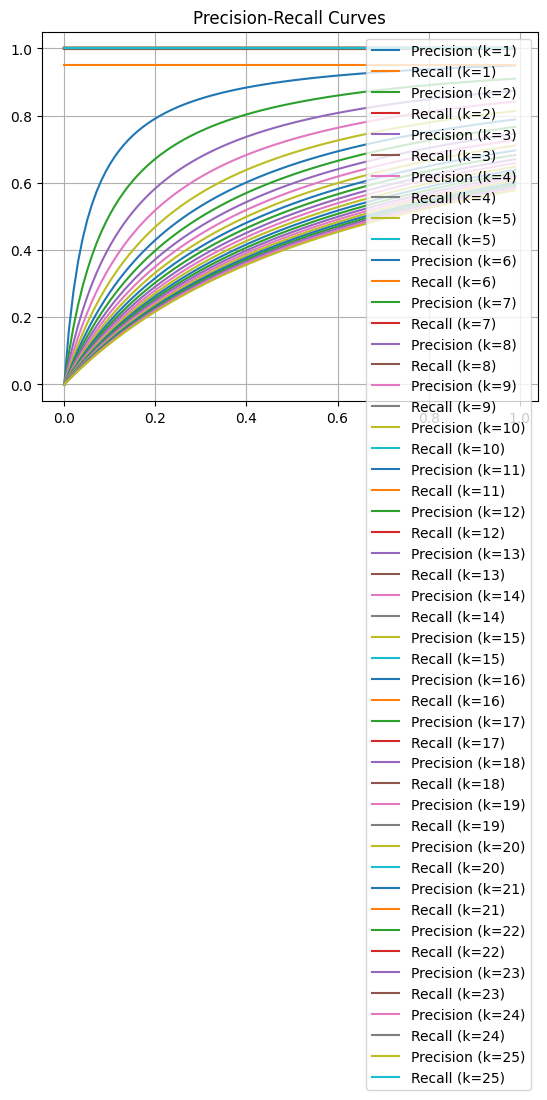

In [27]:
def get_precision(theta, beta, alpha, k=1):
    alpha_k=1-(1-alpha)**k
    beta_k=beta**k
    return (1-beta_k)*theta/((1-beta_k)*theta+alpha_k)

def get_recall(theta, beta, k=1):
    beta_k=beta**k
    return np.ones_like(theta)*(1-beta_k)

for k in range(1, 26):
    precision = get_precision(x, beta, alpha, k)
    recall = get_recall(x, beta, k)
    plt.plot(x, precision, label=f'Precision (k={k})')
    plt.plot(x, recall, label=f'Recall (k={k})')

plt.title('Precision-Recall Curves')

plt.legend()
plt.grid()
plt.show()

3. Consider a strategy with five years of daily IID Normal returns.    
The best trial out of ten yields an annualized Sharpe ratio of 2, where the variance across
the annualized Sharpe ratios is 1.
    1. What is the expected maximum Sharpe ratio? 
    Hint: Apply the False
Strategy theorem.
    2. After one trial, what is the probability of observing a maximum Sharpe
ratio equal or higher than 2? 
    Hint: This is the probabilistic Sharpe ratio.
    3. After ten trials, what is the probability of observing a maximum Sharpe
ratio equal or higher than 2? 
    Hint: This is the deflated Sharpe ratio.

In [28]:
from scipy.stats import norm

def get_expected_max_sr(n_trials:int, mean_sr:float, std_sr:float)->float:
    sharpes_ratio = (1-np.euler_gamma)*norm.ppf(1 - 1/n_trials)+np.euler_gamma*norm.ppf(1 - 1/(np.e*n_trials))
    return mean_sr + sharpes_ratio * std_sr

expected_max_sr=get_expected_max_sr(10, 0.0, 1.0)
print('Expected maximum Sharpe ratio:(Annual)', expected_max_sr)

Expected maximum Sharpe ratio:(Annual) 1.57459830134575


In [29]:
target_sr = 2.0/np.sqrt(252)
T=252*5
z=(target_sr - 0.0) / np.sqrt(1+0.5*target_sr**2/T)
print('Probability of observing a maximum sharpe ratio equal or higher than', target_sr, 'is', 1 - norm.cdf(z))

Probability of observing a maximum sharpe ratio equal or higher than 0.1259881576697424 is 0.4498708063870557


In [30]:
def get_deflated_sharpe_ratio(sr_target:float, mean_sr:float, t, skew, kurtosis):
    val=(sr_target-mean_sr)*np.sqrt(t-1)
    val/=np.sqrt(1-skew*sr_target+(kurtosis-1)/4*sr_target**2)
    return norm.cdf(val)

daily_sr=expected_max_sr/np.sqrt(252)
deflated_sr=get_deflated_sharpe_ratio(target_sr, daily_sr, T, 0.0, 3.0)
print('Deflated Sharpe ratio:', deflated_sr)

Deflated Sharpe ratio: 0.8282057486537355


4. Consider an investment strategy that buys S&P 500 futures when a price
moving average with a short lookback exceeds a price moving average with a
longer lookback.
    1. Generate 1,000 times series of strategy returns by applying different
combinations of
        1.  Short lookback
        2.  Long lookback
        3.  Stop-loss
        4.  Profit taking
        5.  Maximum holding period
    2. Compute the maximum Sharpe ratio out of the 1,000 experiments.
    3. Derive $E[max_k\{\hat{SR_k}\}]$, as explained in Section 8.7.
    4. Compute the probability of observing a Sharpe ratio equal to or higher than
4(b).

In [7]:
import sqlite3

con= sqlite3.connect('../db/sp.db')
tick_df=pd.read_sql_query('''SELECT * FROM sp WHERE "index" BETWEEN '2013-01-01' AND '2020-12-31' ''', con)
tick_df['date'] = pd.to_datetime(tick_df['index'], format='mixed')
tick_df['day'] = tick_df['date'].dt.date
daily_df=tick_df.groupby('day').agg({
    'Close': ['first', 'max', 'min', 'last'],
    'Volume': ['sum']
}).reset_index()
daily_df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']
daily_df.index=pd.to_datetime(daily_df['date'])
daily_df=daily_df.drop(columns=['date'])

In [15]:
def get_strategy_returns(
    price:pd.Series,
    short_lb:int,
    long_lb:int,
    stop_loss:float,
    profit_taking:float, 
    max_holding:int
):
    ma_short = price.rolling(window=short_lb).mean()
    ma_long = price.rolling(window=long_lb).mean()

    signal=(ma_short > ma_long).astype(int)

    bar_returns = price.pct_change().fillna(0)
    strat_ret=np.zeros(price.shape)

    position = 0
    holding_days = 0
    cum_pnl = 0

    for t in range(1, price.shape[0]):
        if position == 0:
            # 진입 조건: 단기 > 장기 → 롱 진입
            if signal.iloc[t] == 1:
                position = 1
                holding_days = 0
                cum_pnl = 0
        else:
            # 포지션 보유 중
            r = bar_returns.iloc[t]
            strat_ret[t] = r * position
            cum_pnl += r
            holding_days += 1

            # 청산 조건
            if cum_pnl <= -stop_loss or cum_pnl >= profit_taking or holding_days >= max_holding:
                position = 0
                cum_pnl = 0
                holding_days = 0

    return pd.Series(strat_ret, index=price.index)


strategies=None
for i in range(1000):
    s = np.random.choice([5,10,15])
    l = np.random.choice([50,100,150,200])
    sl = np.random.choice([0.01,0.02,0.05])
    tp = np.random.choice([0.02,0.04,0.08])
    hp = np.random.choice([5,10,20])
    strat_ret = get_strategy_returns(
        daily_df['close'],
        s, l, sl, tp, hp
    ).iloc[-1000:]
    if strategies is None:
        strategies = pd.DataFrame(strat_ret, columns=[f'ret_{i}'])
    else:
        strategies = pd.concat([strategies, pd.DataFrame(strat_ret, columns=[f'ret_{i}'])], axis=1)

In [ ]:
strategies_sr=strategies.apply(lambda x: (x.mean() / x.std()) if x.std() != 0 else 0, axis=0)
max_strat_ret_sharpe = strategies_sr.max() if not strategies_sr.empty else 0
max_strat_ret_sharpe_idx = strategies_sr.idxmax() if not strategies_sr.empty else None
print('Max Sharpe Ratio:', max_strat_ret_sharpe)

Max Sharpe Ratio: 0.07118482656189255


In [19]:
from optimized_kmean_clustering import KMeansClustering

corr=strategies.corr()
kmeans=KMeansClustering()
cluster_corr, cluster_dict, sil=kmeans.cluster_kmeans_top(corr, max_num_clusters=strategies.shape[1]//10)

In [33]:
def get_opt_port(cov, mu=None):
    cov_inv = np.linalg.pinv(cov)
    ones=np.ones((cov.shape[0], 1))
    if mu is None: mu=ones
    w=cov_inv @ mu / (mu.T @ cov_inv @ mu)
    return w

cluster_strategy_sr=[]
cluster_strategy_returns=[]
for label, cluster_list in cluster_dict.items():
    if len(cluster_list) < 2: continue
    cov = strategies[cluster_list].cov()
    strategy_weights = get_opt_port(cov)
    strategy_returns=  strategies[cluster_list].dot(strategy_weights)
    strategy_sr = strategy_returns.mean() / strategy_returns.std()
    cluster_strategy_sr.append(strategy_sr)
    cluster_strategy_returns.append(strategy_returns)

max_cluster_sr=np.max(cluster_strategy_sr) if cluster_strategy_sr else 0
print('Max Cluster SR:', max_cluster_sr)

Max Cluster SR: 0.07314619606050037


In [32]:
skew=strategies[strategies_sr.idxmax()].skew()
kurtosis=strategies[strategies_sr.idxmax()].kurtosis()
deflated_sr = get_deflated_sharpe_ratio(max_strat_ret_sharpe, max_cluster_sr, 1000, skew, kurtosis)
print('Deflated Sharpe ratio:', deflated_sr)


Deflated Sharpe ratio: 0.47620459495764417


5. Repeat Exercise 4, where this time you compute the familywise Type I and
Type II errors, where $SR^*$ is the median across the 1,000 Sharpe ratios.

In [ ]:
def get_z_stat(sr_e, t, sr_t, skew=0.0, kurosis=3.0):
    z=(sr_e-sr_t)*np.sqrt(t-1)
    z/=np.sqrt((1-skew*sr_e+(kurosis-1)/4*sr_e**2))
    return z

def get_type_one_error(z,k):
    alpha=1-norm.cdf(z)
    alpha_k=1-(1-alpha)**k
    return alpha_k


sr_t=strategies_sr.median()
skew=kurtosis=0.0
for i in range(len(cluster_strategy_sr)):
    if np.isclose(cluster_strategy_sr[i]-max_cluster_sr, 0.0):
        skew=cluster_strategy_returns[i].skew() 
        kurtosis=cluster_strategy_returns[i].kurtosis()
        break
z=get_z_stat(sr_e=max_cluster_sr, t=strategies.shape[0], sr_t=sr_t, skew=skew, kurosis=kurtosis)
alpha_k=get_type_one_error(z, k=len(cluster_dict))
print('Type I Error:', alpha_k)


Type I Error: [0.30103848]


In [39]:
def get_theta(sr_e, t, sr_t, skew=0.0, kurosis=3.0):
    theta=(sr_t*np.sqrt(t-1))/(np.sqrt(1-skew*sr_e+(kurosis-1)/4*sr_e**2))
    return theta

def get_type_two_error(alpha_k, k, theta):
    z=norm.ppf((1 - alpha_k)**(1/k))
    beta=norm.cdf(z - theta)
    return beta

theta=get_theta(sr_e=max_cluster_sr, t=strategies.shape[0], sr_t=sr_t, skew=skew, kurosis=kurtosis)
beta=get_type_two_error(alpha_k=alpha_k, k=len(cluster_dict), theta=theta)
print('Type II Error:', beta)

Type II Error: [0.3560147]


ONC + DSR + FWER 검정을 통과했기 때문에, 최소한 랜덤 과적합이 아니라는 통계적 정당성을 생각할 수 있을것 같다. 